# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [73]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

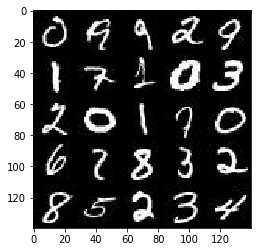

In [74]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

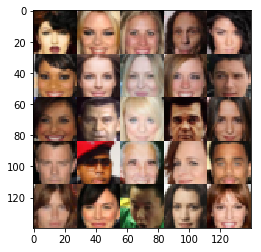

In [75]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [76]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [77]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [78]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.05
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x1 = tf.maximum(alpha * x1, x1)
                        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
                        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
                
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [79]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.5
    stddev = 0.05
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*1024)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)        
                
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
                
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)

        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
                
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [80]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake) * 0.1))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [81]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations 
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [82]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [83]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)                

        saver.save(sess, './generator.ckpt')

    return losses                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.6303
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 1.6111
Epoch 1/2... Discriminator Loss: 0.8366... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 0.6655... Generator Loss: 1.7533
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 2.1457
Epoch 1/2... Discriminator Loss: 0.5455... Generator Loss: 2.4669
Epoch 1/2... Discriminator Loss: 0.6488... Generator Loss: 2.7734
Epoch 1/2... Discriminator Loss: 0.7259... Generator Loss: 2.0821
Epoch 1/2... Discriminator Loss: 1.1900... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 0.7234... Generator Loss: 2.1117


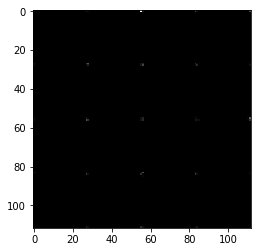

Epoch 1/2... Discriminator Loss: 0.6767... Generator Loss: 1.4518
Epoch 1/2... Discriminator Loss: 0.5176... Generator Loss: 2.1027
Epoch 1/2... Discriminator Loss: 0.5875... Generator Loss: 1.9745
Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 2.6426
Epoch 1/2... Discriminator Loss: 0.4276... Generator Loss: 3.3075
Epoch 1/2... Discriminator Loss: 0.3996... Generator Loss: 3.3397
Epoch 1/2... Discriminator Loss: 0.3836... Generator Loss: 3.6217
Epoch 1/2... Discriminator Loss: 0.3606... Generator Loss: 4.1600
Epoch 1/2... Discriminator Loss: 0.3714... Generator Loss: 4.1956
Epoch 1/2... Discriminator Loss: 0.3894... Generator Loss: 4.9660


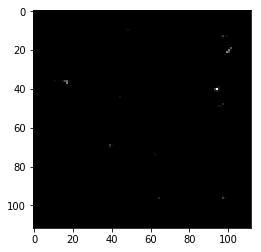

Epoch 1/2... Discriminator Loss: 0.3717... Generator Loss: 5.0603
Epoch 1/2... Discriminator Loss: 0.3578... Generator Loss: 4.7820
Epoch 1/2... Discriminator Loss: 0.3973... Generator Loss: 3.6584
Epoch 1/2... Discriminator Loss: 0.3603... Generator Loss: 4.4057
Epoch 1/2... Discriminator Loss: 0.3525... Generator Loss: 4.4249
Epoch 1/2... Discriminator Loss: 0.3604... Generator Loss: 4.2378
Epoch 1/2... Discriminator Loss: 0.4100... Generator Loss: 3.9067
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 4.8078
Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 5.2137
Epoch 1/2... Discriminator Loss: 0.3473... Generator Loss: 4.8597


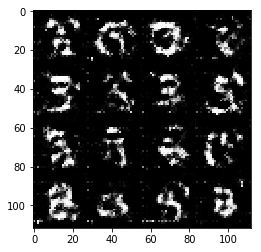

Epoch 1/2... Discriminator Loss: 0.4194... Generator Loss: 6.3452
Epoch 1/2... Discriminator Loss: 0.3412... Generator Loss: 5.5528
Epoch 1/2... Discriminator Loss: 0.3727... Generator Loss: 4.3939
Epoch 1/2... Discriminator Loss: 0.3783... Generator Loss: 6.2594
Epoch 1/2... Discriminator Loss: 0.3389... Generator Loss: 5.5009
Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 5.0974
Epoch 1/2... Discriminator Loss: 0.3459... Generator Loss: 4.9944
Epoch 1/2... Discriminator Loss: 0.3460... Generator Loss: 5.1539
Epoch 1/2... Discriminator Loss: 0.3526... Generator Loss: 4.9957
Epoch 1/2... Discriminator Loss: 0.3723... Generator Loss: 3.9568


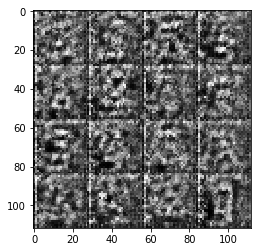

Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 1.1698
Epoch 1/2... Discriminator Loss: 0.5115... Generator Loss: 3.9107
Epoch 1/2... Discriminator Loss: 0.4006... Generator Loss: 3.3396
Epoch 1/2... Discriminator Loss: 0.3921... Generator Loss: 3.6505
Epoch 1/2... Discriminator Loss: 0.4000... Generator Loss: 3.1245
Epoch 1/2... Discriminator Loss: 0.4838... Generator Loss: 2.4836
Epoch 1/2... Discriminator Loss: 0.3625... Generator Loss: 5.8346
Epoch 1/2... Discriminator Loss: 0.5523... Generator Loss: 3.7896
Epoch 1/2... Discriminator Loss: 0.5239... Generator Loss: 2.5229
Epoch 1/2... Discriminator Loss: 0.5409... Generator Loss: 3.1204


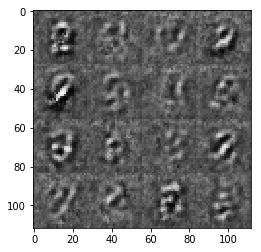

Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 2.4895
Epoch 1/2... Discriminator Loss: 0.5413... Generator Loss: 2.4523
Epoch 1/2... Discriminator Loss: 0.7886... Generator Loss: 1.2284
Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 2.7288
Epoch 1/2... Discriminator Loss: 0.5374... Generator Loss: 1.8614
Epoch 1/2... Discriminator Loss: 1.9702... Generator Loss: 0.3539
Epoch 1/2... Discriminator Loss: 0.5308... Generator Loss: 2.5914
Epoch 1/2... Discriminator Loss: 0.4921... Generator Loss: 2.4042
Epoch 1/2... Discriminator Loss: 0.5663... Generator Loss: 2.2624
Epoch 1/2... Discriminator Loss: 0.7529... Generator Loss: 3.7218


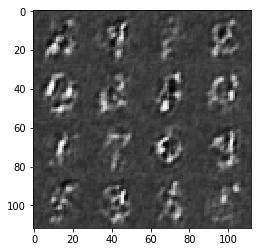

Epoch 1/2... Discriminator Loss: 0.7539... Generator Loss: 4.1104
Epoch 1/2... Discriminator Loss: 0.5100... Generator Loss: 2.2345
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 2.9134
Epoch 1/2... Discriminator Loss: 0.5351... Generator Loss: 1.9712
Epoch 1/2... Discriminator Loss: 0.5163... Generator Loss: 2.2344
Epoch 1/2... Discriminator Loss: 0.5709... Generator Loss: 2.0242
Epoch 1/2... Discriminator Loss: 0.4838... Generator Loss: 2.5053
Epoch 1/2... Discriminator Loss: 0.5440... Generator Loss: 2.1186
Epoch 1/2... Discriminator Loss: 0.5039... Generator Loss: 3.0780
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 2.9715


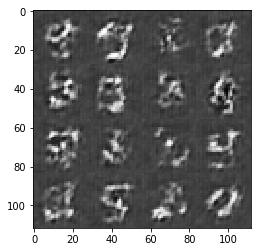

Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 1.5413
Epoch 1/2... Discriminator Loss: 0.4780... Generator Loss: 2.8650
Epoch 1/2... Discriminator Loss: 0.4604... Generator Loss: 2.7189
Epoch 1/2... Discriminator Loss: 0.5088... Generator Loss: 3.1584
Epoch 1/2... Discriminator Loss: 0.4555... Generator Loss: 2.7153
Epoch 1/2... Discriminator Loss: 1.6117... Generator Loss: 0.5021
Epoch 1/2... Discriminator Loss: 0.5030... Generator Loss: 2.6885
Epoch 1/2... Discriminator Loss: 0.4696... Generator Loss: 2.9000
Epoch 1/2... Discriminator Loss: 0.4750... Generator Loss: 3.2671
Epoch 1/2... Discriminator Loss: 0.4473... Generator Loss: 2.7853


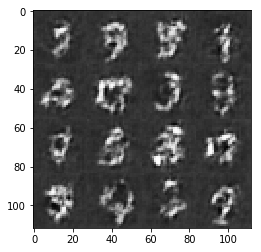

Epoch 1/2... Discriminator Loss: 0.5005... Generator Loss: 3.6967
Epoch 1/2... Discriminator Loss: 0.4586... Generator Loss: 3.0360
Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 4.3933
Epoch 1/2... Discriminator Loss: 0.5440... Generator Loss: 3.0838
Epoch 1/2... Discriminator Loss: 0.4842... Generator Loss: 2.7937
Epoch 1/2... Discriminator Loss: 0.4580... Generator Loss: 2.6115
Epoch 1/2... Discriminator Loss: 0.4678... Generator Loss: 2.6214
Epoch 1/2... Discriminator Loss: 0.4681... Generator Loss: 2.9187
Epoch 1/2... Discriminator Loss: 0.6649... Generator Loss: 1.5542
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.4218


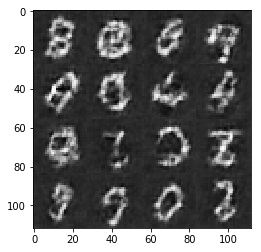

Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 1.0664
Epoch 1/2... Discriminator Loss: 0.5127... Generator Loss: 2.8247
Epoch 1/2... Discriminator Loss: 0.5481... Generator Loss: 3.6397
Epoch 2/2... Discriminator Loss: 0.4416... Generator Loss: 2.8514
Epoch 2/2... Discriminator Loss: 0.4685... Generator Loss: 2.8579
Epoch 2/2... Discriminator Loss: 0.4202... Generator Loss: 3.7059
Epoch 2/2... Discriminator Loss: 0.7199... Generator Loss: 4.2113
Epoch 2/2... Discriminator Loss: 0.4368... Generator Loss: 3.3465
Epoch 2/2... Discriminator Loss: 0.5616... Generator Loss: 4.1745
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 2.6891


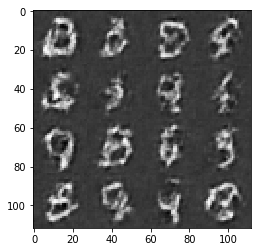

Epoch 2/2... Discriminator Loss: 0.4363... Generator Loss: 2.8883
Epoch 2/2... Discriminator Loss: 0.4311... Generator Loss: 3.1224
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 4.9946
Epoch 2/2... Discriminator Loss: 0.6483... Generator Loss: 1.5725
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 2.6896
Epoch 2/2... Discriminator Loss: 0.4611... Generator Loss: 3.2162
Epoch 2/2... Discriminator Loss: 0.5839... Generator Loss: 1.7626
Epoch 2/2... Discriminator Loss: 0.4425... Generator Loss: 2.5449
Epoch 2/2... Discriminator Loss: 0.4477... Generator Loss: 4.1311
Epoch 2/2... Discriminator Loss: 0.4373... Generator Loss: 3.6377


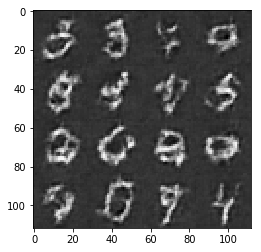

Epoch 2/2... Discriminator Loss: 0.4412... Generator Loss: 3.9529
Epoch 2/2... Discriminator Loss: 0.4274... Generator Loss: 2.7480
Epoch 2/2... Discriminator Loss: 0.5150... Generator Loss: 3.6657
Epoch 2/2... Discriminator Loss: 0.6144... Generator Loss: 1.7748
Epoch 2/2... Discriminator Loss: 0.5651... Generator Loss: 1.9414
Epoch 2/2... Discriminator Loss: 0.4000... Generator Loss: 3.2455
Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 3.2833
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 2.0210
Epoch 2/2... Discriminator Loss: 0.5048... Generator Loss: 2.2482
Epoch 2/2... Discriminator Loss: 0.4227... Generator Loss: 3.3432


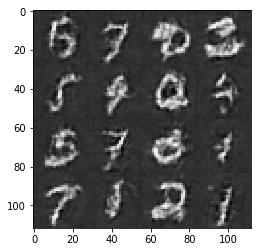

Epoch 2/2... Discriminator Loss: 0.3860... Generator Loss: 3.6979
Epoch 2/2... Discriminator Loss: 0.4222... Generator Loss: 3.8596
Epoch 2/2... Discriminator Loss: 0.5870... Generator Loss: 2.0745
Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 3.2778
Epoch 2/2... Discriminator Loss: 0.4146... Generator Loss: 3.7389
Epoch 2/2... Discriminator Loss: 0.4953... Generator Loss: 3.7612
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 0.5347... Generator Loss: 2.1222
Epoch 2/2... Discriminator Loss: 0.4984... Generator Loss: 2.5149
Epoch 2/2... Discriminator Loss: 0.4954... Generator Loss: 2.3133


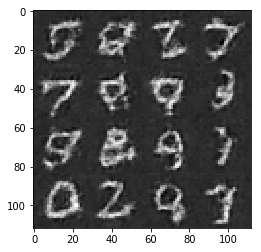

Epoch 2/2... Discriminator Loss: 0.5164... Generator Loss: 2.1194
Epoch 2/2... Discriminator Loss: 0.4731... Generator Loss: 2.4197
Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 3.2220
Epoch 2/2... Discriminator Loss: 0.4341... Generator Loss: 2.9178
Epoch 2/2... Discriminator Loss: 0.4677... Generator Loss: 3.4715
Epoch 2/2... Discriminator Loss: 0.3876... Generator Loss: 3.4549
Epoch 2/2... Discriminator Loss: 0.5528... Generator Loss: 1.9742
Epoch 2/2... Discriminator Loss: 0.4612... Generator Loss: 2.6180
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 3.5334
Epoch 2/2... Discriminator Loss: 0.4149... Generator Loss: 4.3907


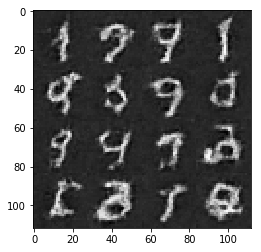

Epoch 2/2... Discriminator Loss: 0.3665... Generator Loss: 4.8443
Epoch 2/2... Discriminator Loss: 0.3743... Generator Loss: 4.1781
Epoch 2/2... Discriminator Loss: 0.4062... Generator Loss: 3.0397
Epoch 2/2... Discriminator Loss: 0.4225... Generator Loss: 2.8905
Epoch 2/2... Discriminator Loss: 0.4659... Generator Loss: 2.6399
Epoch 2/2... Discriminator Loss: 0.4769... Generator Loss: 3.8024
Epoch 2/2... Discriminator Loss: 0.3985... Generator Loss: 3.4830
Epoch 2/2... Discriminator Loss: 0.4372... Generator Loss: 2.8286
Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 3.8147
Epoch 2/2... Discriminator Loss: 0.3650... Generator Loss: 4.2338


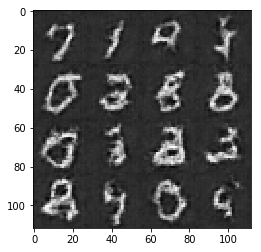

Epoch 2/2... Discriminator Loss: 0.9669... Generator Loss: 4.8026
Epoch 2/2... Discriminator Loss: 0.4921... Generator Loss: 2.8044
Epoch 2/2... Discriminator Loss: 0.4728... Generator Loss: 2.4225
Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 2.6301
Epoch 2/2... Discriminator Loss: 0.4956... Generator Loss: 2.1636
Epoch 2/2... Discriminator Loss: 0.4746... Generator Loss: 2.4527
Epoch 2/2... Discriminator Loss: 0.4153... Generator Loss: 2.8901
Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 2.6336
Epoch 2/2... Discriminator Loss: 0.3931... Generator Loss: 3.5670
Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 3.5636


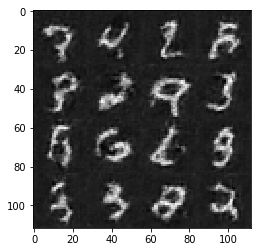

Epoch 2/2... Discriminator Loss: 0.4022... Generator Loss: 3.4175
Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 3.4331
Epoch 2/2... Discriminator Loss: 0.3697... Generator Loss: 3.8922
Epoch 2/2... Discriminator Loss: 0.3867... Generator Loss: 3.8016
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 3.5320
Epoch 2/2... Discriminator Loss: 0.3854... Generator Loss: 3.3936
Epoch 2/2... Discriminator Loss: 0.3585... Generator Loss: 5.0048
Epoch 2/2... Discriminator Loss: 0.4185... Generator Loss: 3.7387
Epoch 2/2... Discriminator Loss: 0.4851... Generator Loss: 4.3993
Epoch 2/2... Discriminator Loss: 0.4282... Generator Loss: 2.7905


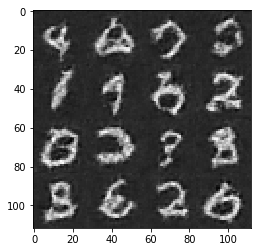

Epoch 2/2... Discriminator Loss: 0.4039... Generator Loss: 3.4649
Epoch 2/2... Discriminator Loss: 0.4892... Generator Loss: 2.5684
Epoch 2/2... Discriminator Loss: 0.4745... Generator Loss: 3.3088
Epoch 2/2... Discriminator Loss: 1.2791... Generator Loss: 5.3627
Epoch 2/2... Discriminator Loss: 0.4239... Generator Loss: 3.0004
Epoch 2/2... Discriminator Loss: 0.4089... Generator Loss: 3.2221
Epoch 2/2... Discriminator Loss: 0.3685... Generator Loss: 3.9484
Epoch 2/2... Discriminator Loss: 0.4300... Generator Loss: 3.9498
Epoch 2/2... Discriminator Loss: 0.3932... Generator Loss: 3.5807
Epoch 2/2... Discriminator Loss: 0.3819... Generator Loss: 4.7864


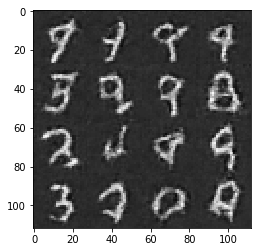

Epoch 2/2... Discriminator Loss: 0.4112... Generator Loss: 4.0635
Epoch 2/2... Discriminator Loss: 0.4620... Generator Loss: 3.4378
Epoch 2/2... Discriminator Loss: 0.4171... Generator Loss: 3.1547
Epoch 2/2... Discriminator Loss: 0.4952... Generator Loss: 2.2859
Epoch 2/2... Discriminator Loss: 0.3938... Generator Loss: 3.5921
Epoch 2/2... Discriminator Loss: 0.3707... Generator Loss: 4.5258
Epoch 2/2... Discriminator Loss: 0.3843... Generator Loss: 3.5694


In [85]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5547... Generator Loss: 2.6597
Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 2.3134
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 3.6664
Epoch 1/1... Discriminator Loss: 0.4792... Generator Loss: 2.5699
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 3.4191
Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 2.7900
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 3.3076
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 3.7768
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 4.0318
Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 4.8139


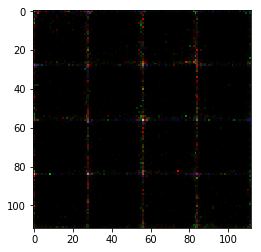

Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 4.0085
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 4.3508
Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 5.3141
Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 4.2871
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 4.5026
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 4.7202
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 4.5635
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 4.1449
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 5.2739
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 4.3732


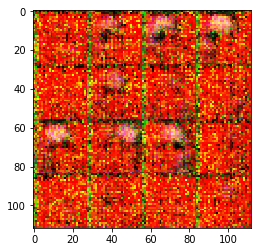

Epoch 1/1... Discriminator Loss: 0.3679... Generator Loss: 4.2441
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 3.1022
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 5.3988
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 4.9563
Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 3.0774
Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 4.0118
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 3.3346
Epoch 1/1... Discriminator Loss: 2.1588... Generator Loss: 11.5281
Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 5.5802
Epoch 1/1... Discriminator Loss: 0.3711... Generator Loss: 4.2396


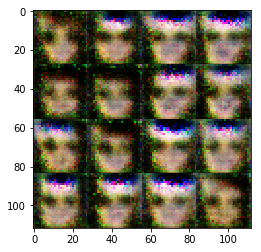

Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 4.2342
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 5.3621
Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 2.9835
Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 4.0971
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 2.6300
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 3.0750
Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 2.6292
Epoch 1/1... Discriminator Loss: 0.5126... Generator Loss: 2.8895
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 1.9548


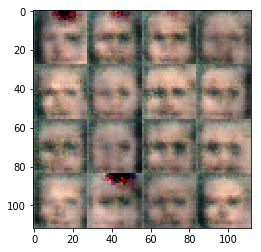

Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 6.4459
Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 2.6742
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 2.6189
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 3.7599
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 2.8176
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 3.9850
Epoch 1/1... Discriminator Loss: 4.8720... Generator Loss: 8.0744
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 2.6706
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 2.5720
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 1.9319


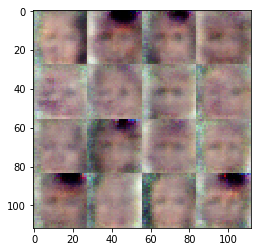

Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 2.9337
Epoch 1/1... Discriminator Loss: 0.4586... Generator Loss: 3.2621
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 2.5427
Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 3.4976
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 3.5105
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 3.1104
Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 4.2968
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 4.0729
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 3.6843


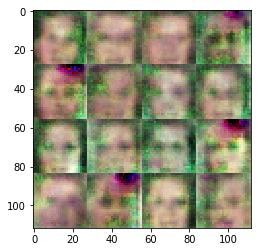

Epoch 1/1... Discriminator Loss: 0.4533... Generator Loss: 2.7195
Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 4.3977
Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 2.9803
Epoch 1/1... Discriminator Loss: 0.3752... Generator Loss: 4.1381
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 2.7722
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 2.2627
Epoch 1/1... Discriminator Loss: 0.4433... Generator Loss: 4.4144
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 1.9082
Epoch 1/1... Discriminator Loss: 0.5183... Generator Loss: 1.9445
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 1.8525


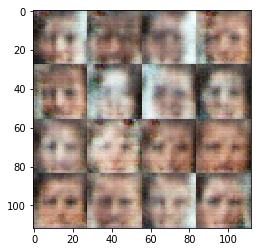

Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 6.3843
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 3.7576
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 2.4756
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 3.7686
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 4.2218
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 2.6014
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 2.2554
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 2.2176
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 3.0694


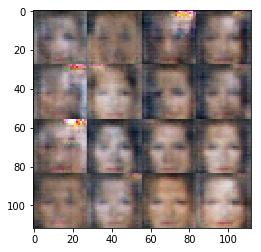

Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 7.9778
Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 2.9747
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 3.4149
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 2.6678
Epoch 1/1... Discriminator Loss: 0.3548... Generator Loss: 4.6422
Epoch 1/1... Discriminator Loss: 1.6655... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 2.6253


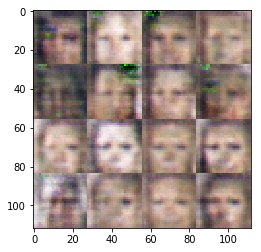

Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 2.4696
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 2.0279
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 5.3028
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 4.5585
Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 6.2312
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 7.2331
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 6.3365
Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 2.3224
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.3911
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 0.4035


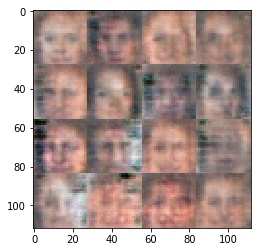

Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.7602
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.3293
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 1.5065
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 2.0739


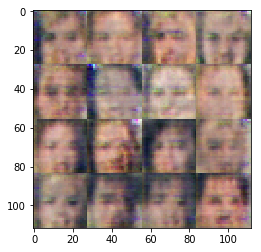

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.2611
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.0538


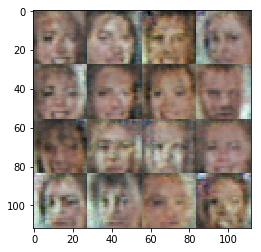

Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.8906


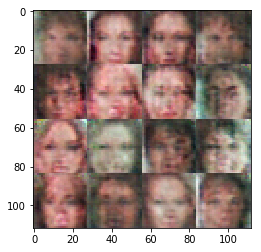

Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 3.0070
Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 4.0711
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.2200
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.0257


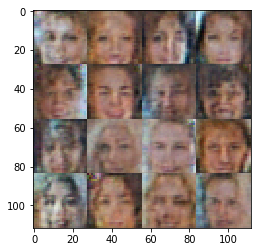

Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 0.5318... Generator Loss: 2.5327
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.8432
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 3.9564
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.5115
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.3750
Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.9215


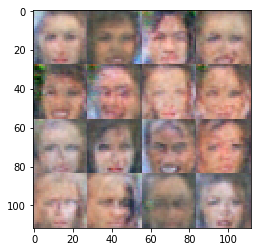

Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 1.8796
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.0192


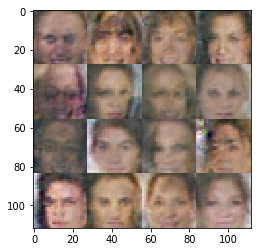

Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.6552
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.8822... Generator Loss: 0.2979
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.8123


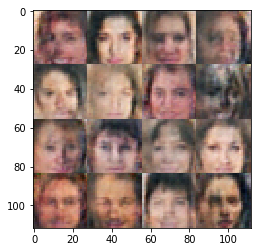

Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 2.1003... Generator Loss: 0.2522
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 2.4601
Epoch 1/1... Discriminator Loss: 0.6697... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.4275
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6563


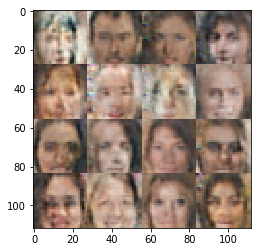

Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.0205
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.4916


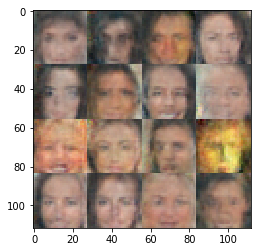

Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.7615


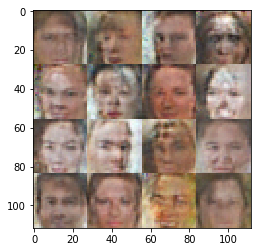

Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.4521
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.5279


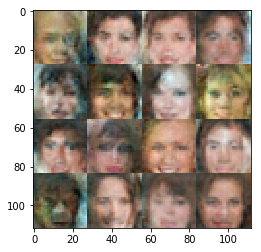

Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.3445
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 2.2170
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.1754


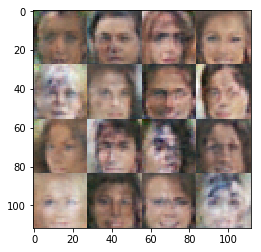

Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.4797
Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 1.7400
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 1.1002
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.5537
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7646


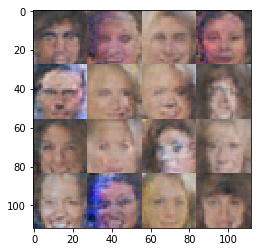

Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.8613


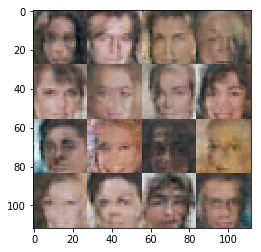

Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.0820... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.7634


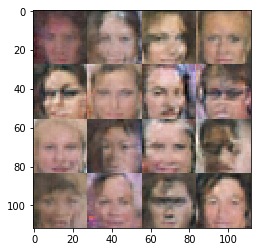

Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.4927
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.0977


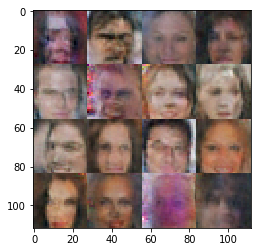

Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 1.5402
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6956


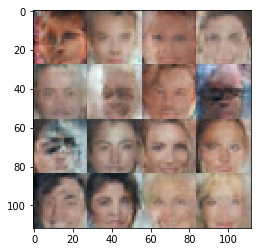

Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 1.0033
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.6421


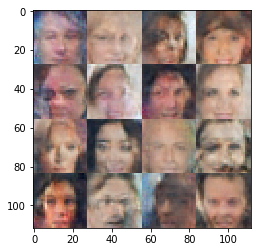

Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.3428
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.0915
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 2.0131
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.6462


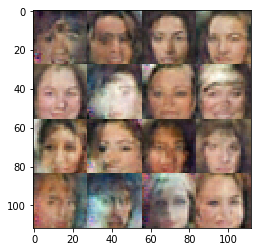

Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 2.6424
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.2363
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.7934


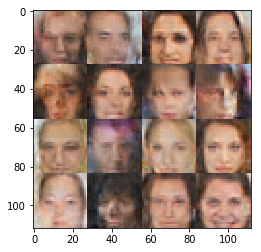

Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6729


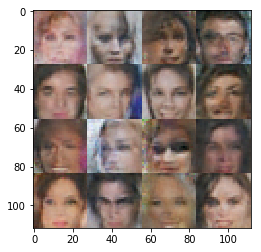

Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.9750


In [84]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.